# Classification

## Introduction

Classification is an extremely useful tool within machine learning used to categorize data with labels based upon 1 or more features. Classification can be used to categorize data for many use cases, including patient diagnosis. The basic concept is that you have a dataset with multiple features that are associated with known labels, for example you might have a dataset with multiple diagnostic factors and a field identifying whether a patient is positive for that diagnosis. Using classification, we could train a model to predict, based upon those factors, whether another patient not included in the dataset is positive as well. Classification models can be used to predict between 2 labels (binary classification as described), or between 3 or more labels (ex. low, middle, high income). 

In this example, we are going to use binary classification to predict customer retention based on multiple demographic and behavioral factors. Not only will this project demonstrate how to build classification models using python, but we will also examine how to evaluate the strength of these models and compare them to each other.

### Preparation

First, we need to import the packages and define some custom functions to be used within our analysis and then import our dataset which we will use to train the models.

In [1]:
# Import Packages
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn. metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import openpyxl

In [2]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 240)
pd.set_option('display.max_rows', None)

In [7]:
# Define Functions
def show_distribution(var_data, x_label,plot_title):

    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (10,4))

    # Plot the histogram
    ax[0].hist(var_data)
    ax[0].set_ylabel('Frequency')

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'blue', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot
    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel(x_label)

    # Add a title to the Figure
    fig.suptitle(plot_title)

    # Show the figure
    plt.show()

In [5]:
# Import Data
customer_df = pd.read_excel("Customers.xlsx")
print(customer_df.tail())

     Customer_ID  Age         Income  Retention  Years  Total Sales  Total Transactions
495          482   74  356338.888889   9.185956      9   669.662050                   9
496          497   67  398920.833333   9.310885      9   252.595625                   7
497          494   69  388421.888889   9.336460      9  3702.660380                  18
498          483   74  363658.333333   9.374642      9  1191.280217                   6
499          500   69  410441.000000   9.865731      9  4629.713197                  15


Now that we have imported our data and printed the dataframe, you can see that we have 500 customer records with details about their age, income and multiple variables related to their purchase history. In this use case, we are going to use classification to determine if we can build a reliable model to predict whether customers will be retained long term using our dataset. Before we begin building the model, let's create some visualizations to help us explore the data.

Minimum:0.00
Mean:2.91
Median:3.00
Mode:2.00
Maximum:9.00



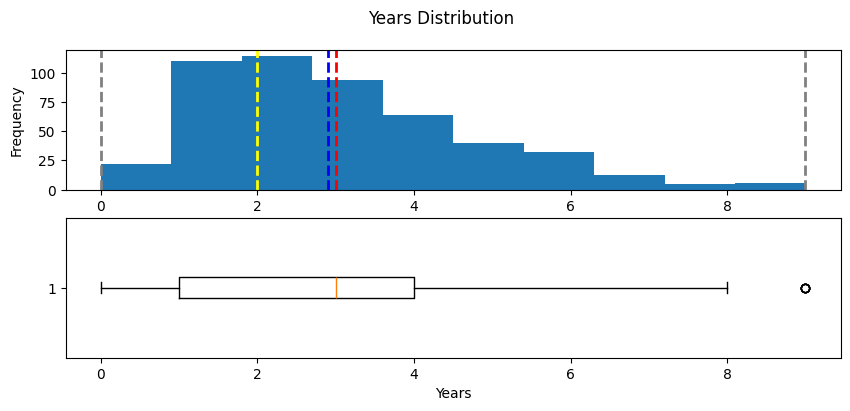

In [8]:
# Visual - Distribution of Years
customer_data = customer_df['Years']
show_distribution(customer_data,'Years','Years Distribution')

Since we are attempting to categorize customer by retention, we have displayed the distribution and boxplot for Years (number of whole years since a customer's first purchase). Based upon the graphs above, you can see that the data is right-skewed and that the median retention period is about 3 years. In this example, we are going to assess whether any of the factors in our dataset can predict retention beyond 3 years. To do this, we first need to add a categorical variable to designate whether someone has been a customer for 3 or more years. This will be our known label that we are attempting to predict.

In [9]:
# Add Retention Label
customer_df['Customer_Term'] = customer_df['Years']>3
print(customer_df.head())
print(customer_df.tail())

   Customer_ID  Age         Income  Retention  Years  Total Sales  Total Transactions  Customer_Term
0            5   26   61903.333333   0.560682      0  2068.955246                   2          False
1           20   21   79030.111111   0.578151      0  2117.746045                   2          False
2           28   21   83629.166667   0.611796      0  3427.275560                   1          False
3           13   27   70946.000000   0.667300      0   423.171906                   2          False
4           62   20  106988.555556   0.745413      0  3984.502214                   2          False
     Customer_ID  Age         Income  Retention  Years  Total Sales  Total Transactions  Customer_Term
495          482   74  356338.888889   9.185956      9   669.662050                   9           True
496          497   67  398920.833333   9.310885      9   252.595625                   7           True
497          494   69  388421.888889   9.336460      9  3702.660380                  

Now that we have our known label, we need to separate our predictor features from the known label.

In [10]:
# Separate features and labels
features = ['Age','Income','Total Sales','Total Transactions']
label = 'Customer_Term'
X, y = customer_df[features].values, customer_df[label].values

Now let's explore the data further by looking at the boxplots of each of our predictor variables broken down by retention period.

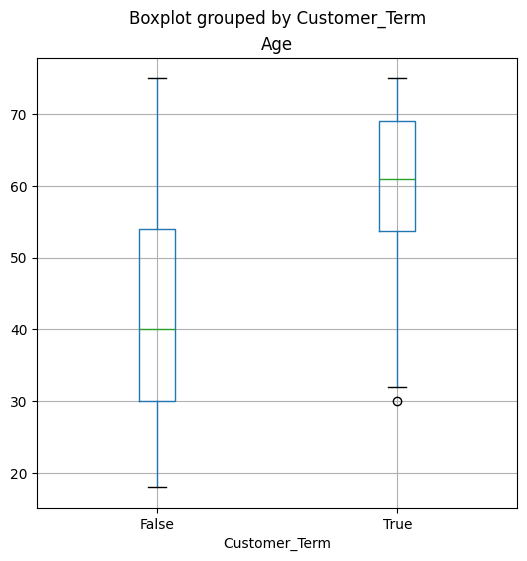

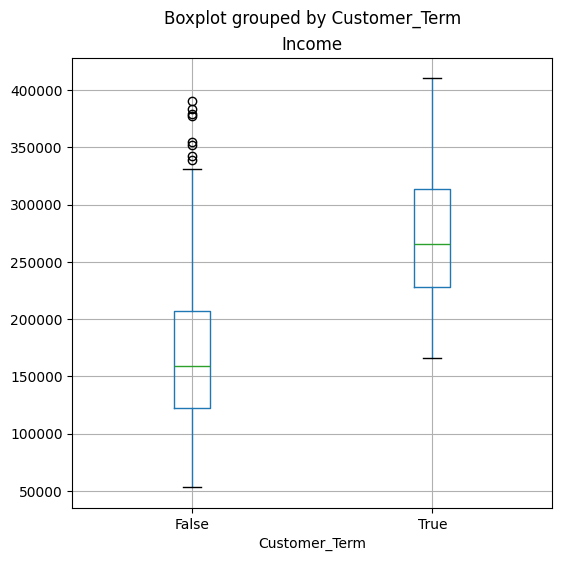

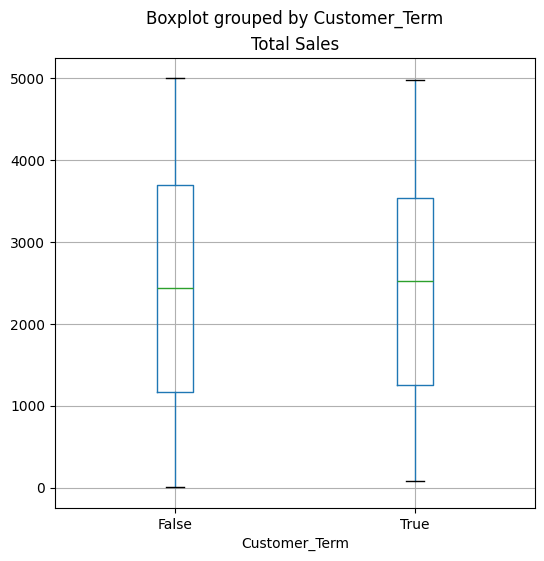

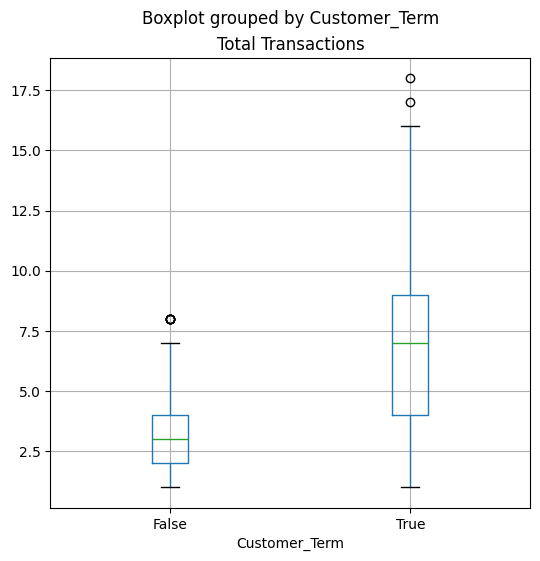

In [11]:
# Print the boxplots showing the distribution of each feature by term
for col in features:
    customer_df.boxplot(column=col, by='Customer_Term', figsize=(6,6))
    plt.title(col)
plt.show()

Based upon these boxplots, you can see that there are 3 factors which show a substantial difference in retention, age, income and total transactions. Total sales on the other hand seems to show no difference in customer retention.

We are going to build multiple classification models using these features and then evaluate how they perform. First we need to split our data into 2 groups, a training set that we will use to train the model and a test set that we will use to evaluate their performance. The first model we will build will use all of the features as independent variables and the second model wil use only total transactions as its predictive feature.

In [18]:
# Model 1 - ALL Features
# Split data 70%-30% into training set and test set
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.30, random_state=0)
print ('Training cases: %d\nTest cases: %d' % (X_train1.shape[0], X_test1.shape[0]))

# Set regularization rate
reg = 0.01
# train a logistic regression model on the training set
model1 = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train1, y_train1)
print (model1)


predictions1 = model1.predict(X_test1)
print('Predicted labels (Sample): ', predictions1[0:4])
print('Actual labels (Sample):    ', y_test1[0:4])

print('Accuracy: ', accuracy_score(y_test1, predictions1))

Training cases: 350
Test cases: 150
LogisticRegression(C=100.0, solver='liblinear')
Predicted labels (Sample):  [ True  True False False]
Actual labels (Sample):     [False False False  True]
Accuracy:  0.62


In [19]:
# Model 2 - Total Transactions
# Separate features and labels
features = ['Total Transactions']
label = 'Customer_Term'
X2, y2 = customer_df[features].values, customer_df[label].values

# Split data 70%-30% into training set and test set
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.30, random_state=0)
print ('Training cases: %d\nTest cases: %d' % (X_train2.shape[0], X_test2.shape[0]))

# Set regularization rate
reg = 0.01
# train a logistic regression model on the training set
model2 = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train2, y_train2)
print (model2)


predictions2 = model2.predict(X_test2)
print('Predicted labels (Sample): ', predictions2[0:4])
print('Actual labels (Sample):    ', y_test2[0:4])

print('Accuracy: ', accuracy_score(y_test2, predictions2))

Training cases: 350
Test cases: 150
LogisticRegression(C=100.0, solver='liblinear')
Predicted labels (Sample):  [False False False  True]
Actual labels (Sample):     [False False False  True]
Accuracy:  0.76


In [23]:
print("Model 1 (All Features) \n",classification_report(y_test1, predictions1))
print("Model 2 (Total Transaction Only) \n",classification_report(y_test2, predictions2))

Model 1 (All Features) 
               precision    recall  f1-score   support

       False       0.72      0.70      0.71       100
        True       0.43      0.46      0.45        50

    accuracy                           0.62       150
   macro avg       0.58      0.58      0.58       150
weighted avg       0.63      0.62      0.62       150

Model 2 (Total Transaction Only) 
               precision    recall  f1-score   support

       False       0.76      0.93      0.84       100
        True       0.75      0.42      0.54        50

    accuracy                           0.76       150
   macro avg       0.76      0.68      0.69       150
weighted avg       0.76      0.76      0.74       150



The classification reports for each model show multiple factors used to evaluate performance for classification models. Precision measures the proportion of correct predictions by each model for a given class whereas recall measures the proportion of records falling into a given class which were correctly identified by the model. F1 is an average score taking both precision and recall into account and support is the number of records within each class.

Based upon these tables, you can see that the 2nd model, using only total transaction as a predictive variable, substantially outperformed the full model using all features in most metrics. Another way to assess the performance of a classification model is to use an ROC curve and calculate the AUC (area under the curve). Classification algorithms like those we have built are not actually predicting a precise 0 or 1 class label. Rather, they predict a probability between 0 and 1. Whether that probability falls above or below a certain threshold, often 0.5 for binary classification, will determine which label the model predicts.

ROC curve charts show the true positive rate and false positive rates mapped against a range of thresholds. Let's produce these charts for each of our models and interpret their meaning.

In [24]:
y_scores1 = model1.predict_proba(X_test1)
print("Y Scores model 1",y_scores1[0:4])
y_scores2 = model2.predict_proba(X_test2)
print("Y Scores model 2",y_scores2[0:4])

Y Scores model 1 [[0.3912829  0.6087171 ]
 [0.42139234 0.57860766]
 [0.60012395 0.39987605]
 [0.57177586 0.42822414]]
Y Scores model 2 [[0.84263804 0.15736196]
 [0.54373035 0.45626965]
 [0.76442881 0.23557119]
 [0.03453147 0.96546853]]


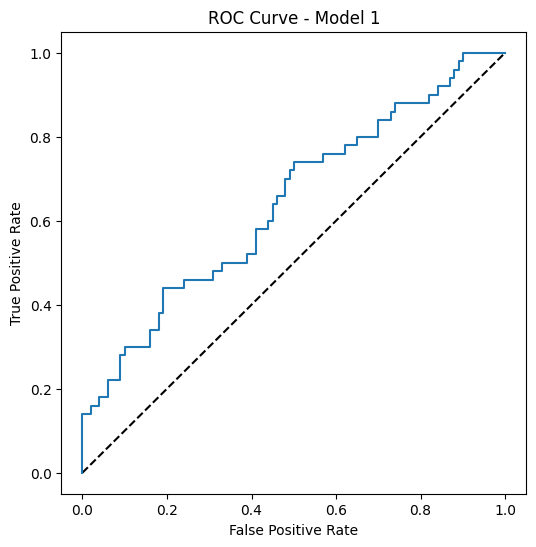

AUC: 0.6408


In [25]:
# MODEL 1 - ROC Curve
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test1, y_scores1[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model 1')
plt.show()
auc = roc_auc_score(y_test1,y_scores1[:,1])
print('AUC: ' + str(auc))

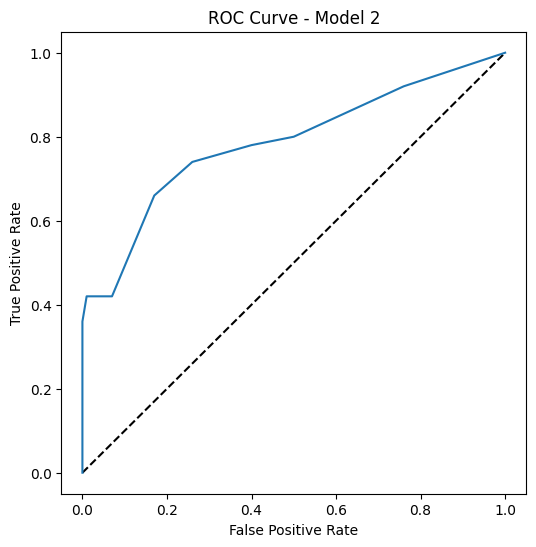

AUC: 0.7855000000000001


In [26]:
# MODEL 2 - ROC Curve
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test2, y_scores2[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model 2')
plt.show()
auc = roc_auc_score(y_test2,y_scores2[:,1])
print('AUC: ' + str(auc))

Each of the charts above has a dashed diagonal line representing the probability of making a correct prediction via random guessing. The curved blue lines show the curve of the models themselves. A perfect model would show a curved line that extends vertically to the top of the chart and then horizontally to the right. The higher the curve, the greater the area under the curve. The AUC calculates the overall performance of the model as a metric between 0 and 1. The closer the AUC is to 1, the better the model. In this case you can see that Model 2, using only total transactions, substantially out performed model 1 (AUC of 0.785 and 0.641, respectively). 

But perhaps we can do better. Model 1 used all features within its predictions, but the variables were on difference scales. In this model we used age (ranging between 18-75), income (~50000->400000), total transactions (1-18) and total sales ranging in the thousands. Because these ranges are so different, our model likely is biased towards some variables. In order to account for this, we can normalize the features by changing them to be on the same scale, which may improve model performance. To do this we will create a pipeline to transform the data, prior to building our model.

Accuracy: 0.9533333333333334
Overall Precision: 0.9215686274509803
Overall Recall: 0.94
AUC: 0.9912000000000001
Model 3 (Normalized Variables) 
               precision    recall  f1-score   support

       False       0.97      0.96      0.96       100
        True       0.92      0.94      0.93        50

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



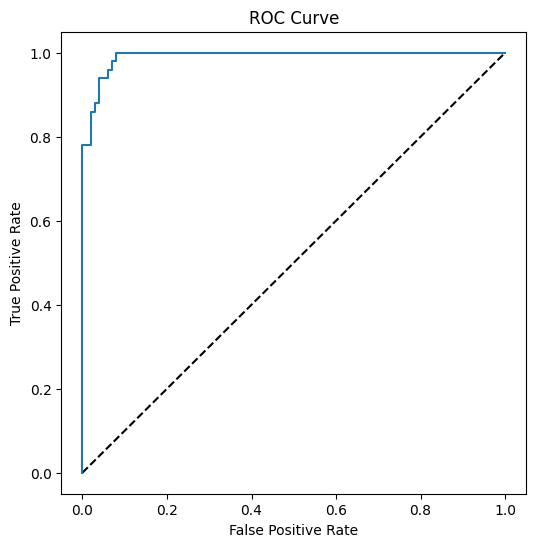

In [33]:
# MODEL 3 - Model 1 with Normalized Features
# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_features = [0,1,2,3]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', LogisticRegression(C=1/reg, solver="liblinear"))])


# fit the pipeline to train a logistic regression model on the training set
model3 = pipeline.fit(X_train1, (y_train1))
# print (model3)

# Get predictions from test data
predictions = model3.predict(X_test1)
y_scores1 = model3.predict_proba(X_test1)

# Get evaluation metrics
print('Accuracy:', accuracy_score(y_test1, predictions))
print("Overall Precision:", precision_score(y_test1, predictions))
print("Overall Recall:", recall_score(y_test1, predictions))
auc = roc_auc_score(y_test1,y_scores1[:,1])
print('AUC: ' + str(auc))
print("Model 3 (Normalized Variables) \n",classification_report(y_test1, predictions))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test1, y_scores1[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Conclusion

After normalizing the predictor features, we can see substantial improvement in our third model. If we were to explore this further, we might consider whether we could remove some variables and achieve similar or better results (perhaps we could remove total sales and still see similar performance). It is often the case that models which produce highly accurate prediction contain more features than are needed. Generally, it is best practice to reduce models down to the fewest necessary features to create the desired performance since these are more elegant in nature and eliminate noise within the model. 

Additionally, even though we find that these factors can be used to create a highly accurate model, this does not prove causation. It may be the case, for example, that there is a causal relationship between total transactions and the length of time someone has been a customer, but that relationship could be in either direction, depending on whether we are selling subscription services or executing one-time transactions. The purpose of this project is to show how to create classification models and evaluate their performance. If this were applied in reality, we would use our domain expertise to further refine these models and build additional tests to determine causailty.